<a href="https://colab.research.google.com/github/shafkat2/Denoising-Time-Series-Data-and-Finding-Peaks-using-Unsupervised-methods/blob/main/fuel_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Functions and Imports

***Libraries***

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
!pip install xlrd
from scipy import signal
import random
from scipy.interpolate import interp1d
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,RepeatVector,TimeDistributed
from tensorflow.keras.layers import LSTM,Dropout,Bidirectional,GRU
from sklearn.metrics import mean_squared_error
import math
import time as time
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from scipy.signal import medfilt
from scipy.signal import savgol_filter
from keras.models import model_from_json
import pywt
from statsmodels.robust import mad
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
from keras.layers import Conv1D, Input, Add, Activation, Dropout

from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.initializers import TruncatedNormal
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras import optimizers
from scipy.signal import sosfiltfilt, butter
#from pandas.tools.plotting import table
import matplotlib.dates as md


Using TensorFlow backend.


***Denosing Module***

In [ ]:

count = 1  #global variable
min_max_scaler = preprocessing.MinMaxScaler()
#helper_function
def Zero_noise(df,X):
  
  da = df[X] <= 0 
  
  dm = df.copy(deep=True)
  dm[da] = None
  df = dm[X].iloc[:]
  df = pd.DataFrame(df)
  ward_list = fill_nans_scipy1(df.values)
  ward_list = pd.DataFrame(ward_list)
  plt.figure(1)
  plt.subplot(212) 
  plt.plot(ward_list)
  plt.savefig('/content/drive/My Drive/Machine_Learning/removing zero noise.png')
  return ward_list

def refill_concatenate(df,x,col,ranges):
  global count
  group = "Refill "
  if x+1 <= df.shape[0]-1:
    if df[col].iloc[x+1] - df[col].iloc[x] <= ranges:
      
      return count     # count is used a counting mechanism for counting the index
    else:
      count = count +1
      return count-1
  else:
      return count

def  minMaxScaler(Df):
  # Create a minimum and maximum processor object
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(Df)
  df_normalized = pd.DataFrame(x_scaled)
  return df_normalized


def fill_nans_scipy1(padata, pkind='nearest'):
  #interpolates and expterpolates to calculate the values
  if(np.isnan(padata).any()):
    aindexes = np.arange(padata.shape[0])          
    agood_indexes = np.where(np.isfinite(padata))
    b = padata[agood_indexes[0]].squeeze()
    a = agood_indexes[0]
    f = interp1d(a, b, bounds_error=False, copy=False, fill_value="extrapolate",kind=pkind)
    
    return f(aindexes)
  else:
    return padata


def filter(a,window_median,polyorder,window_golay,mode,filters):
  #median and sav_golay_filter
  #a.iloc[1,0] 0 column and 1 index
  X_med = []
  if(filters == "median"):
    
    for i in range(0, a.shape[0]):
        X_med.append(a.iloc[i,0])
    X_med = medfilt(X_med,window_median)
    X_med = pd.DataFrame(X_med)
    plt.figure(1)
    plt.subplot(211)
    plt.plot(X_med, label='After inter-polation')
    
  elif(filters == "sav"):
    
    for i in range(0, a.shape[0]):
        X_med.append(a.iloc[i,0])
    X_med  = savgol_filter(X_med ,window_length=window_golay,polyorder= polyorder,mode = mode )
    plt.subplot(212)
    plt.plot(X_med, label='After inter-polation')
    X_med = pd.DataFrame(X_med)
    
  elif(filters == "both"):
    
    for i in range(0, a.shape[0]):
       X_med.append(a.iloc[i,0])
        
    X_med = medfilt(X_med,window_median)
    plt.figure(1)
    plt.subplot(211)
    plt.plot(X_med, label='After inter-polation')

    X_med  = savgol_filter(X_med ,window_length=window_golay,polyorder= polyorder,mode = mode )
    plt.subplot(212)
    plt.plot(X_med, label='After inter-polation')
    X_med = pd.DataFrame(X_med)
    X_med =  X_med.astype('float64')
  
  return X_med

def filter_method(S,refill_aggregate,filters,wl,div):  
  #start is bigger stop is smaller,
  # indexing dont count the last index
  S_test_final = pd.DataFrame()
  X_start = 0
  ranges = 0
  if refill_aggregate.shape[0] > 0:
    for x in range(refill_aggregate.shape[0]):
      if int((refill_aggregate["Index_start"].iloc[x]-X_start-wl)/div)% 2 == 0:
        ranges = int((refill_aggregate["Index_start"].iloc[x]-X_start-wl)/div)-1
      else:
        ranges = int((refill_aggregate["Index_start"].iloc[x]-X_start-wl)/div)
 
      S_test1 = filter(S[ X_start:refill_aggregate["Index_start"].iloc[x]-wl],window_median = ranges ,polyorder = 1,window_golay = ranges,mode = "interp",filters = filters)
      S_test2 = S[refill_aggregate["Index_start"].iloc[x]-wl:refill_aggregate["Index_stop"].iloc[x]+wl]
      X_start = refill_aggregate["Index_stop"].iloc[x]+wl
      S_list = [S_test1,S_test2]
      for x in range(len(S_list)):
        S_test_final = S_test_final.append(S_list[x], ignore_index=True)
    if int(( S.shape[0] - (refill_aggregate["Index_stop"].iloc[refill_aggregate.shape[0]-1]+wl))/div)% 2 == 0:
      ranges = int(( S.shape[0] - (refill_aggregate["Index_stop"].iloc[refill_aggregate.shape[0]-1]+wl))/div)-1
    else:
      ranges = int(( S.shape[0] - (refill_aggregate["Index_stop"].iloc[refill_aggregate.shape[0]-1]+wl))/div)
    #shape refill is 0 no peak detected  and -1 for not getting out of bounds to select the last point
    S_test1 = filter(S[refill_aggregate["Index_stop"].iloc[refill_aggregate.shape[0]-1]+wl:],window_median = ranges ,polyorder = 1,window_golay = ranges,mode = "interp",filters = filters)    
    S_test_final = S_test_final.append(S_test1, ignore_index=True)
  else:
    if int(( S.shape[0] - (X_start))/div)% 2 == 0:
      ranges = int(( S.shape[0] - (X_start))/div)-1
    else:
      ranges = int(( S.shape[0] - (X_start))/div)
      
      
    S_test1 = filter(S[X_start:],window_median = ranges ,polyorder = 1,window_golay = ranges,mode = "interp",filters = filters)
    S_test_final = S_test_final.append(S_test1, ignore_index=True)
  return  S_test_final

def new_feature_analysis(Volume_new_Feature):
  #add a new feature volume
  Volume = Volume_new_Feature.copy(deep = True)
  volume_np = [0]
  for i in range(Volume.shape[0]-1):
        volume_np.append(Volume.iloc[i+1, 0]-Volume.iloc[i, 0])

  vol = pd.DataFrame(volume_np)
  Volume = Volume.assign(volume  = vol)
  plt.plot(Volume["volume"] , marker='', color='red', linewidth=2)
  plt.plot(Volume[0], marker='', color='black', linewidth=2, label="toto")
  return Volume

###CLustering Part1

def Clustering(Data,batch_size,alpha,tuneing): 
  #Hiearchal CLustering
  batch_s = batch_size
  ward_list = []
  label = []
  mini_batch = int(batch_size/tuneing) 
  size1 = 0
  size2 =  batch_s
  data = []        
  count_row_test = Data.shape[0]
  num_batches =int(round(count_row_test/ batch_s)) 
  for x in range(num_batches):
      
    batch2 = Data.iloc[size1:size2]
    size_new1 = size1
    size_new2 = size1+mini_batch
    if(batch2.std().values<alpha):
      for i in range(tuneing):
        batch2 = Data.iloc[size_new1:size_new2]
        batch_noise = batch2.values.reshape( batch2.shape[0],1)
        #print("Compute unstructured hierarchical clustering...")
        if(batch2.shape[0]> 1):
          print("spectral",x*batch_size)
          #connectivity = kneighbors_graph(batch_noise, n_neighbors=batch2.shape[0]-1, include_self=False)
          ward = SpectralClustering(n_clusters=2,  assign_labels="discretize", random_state=0).fit(batch_noise)
          ward_list.append(ward)
          data.append(batch2.values)
          label.append(ward.labels_)         
          size_new1 = size_new1+mini_batch
          size_new2 = size_new2+mini_batch
    else:
      print("Agglomerative",x*batch_size)
      batch_noise = batch2.values.reshape( batch2.shape[0],1)
      connectivity = kneighbors_graph(batch_noise, n_neighbors=batch2.shape[0]-1, include_self=False)
      ward = AgglomerativeClustering(n_clusters=2,connectivity=connectivity, linkage='single').fit(batch_noise)
      ward_list.append(ward)
      data.append(batch2.values)
      label.append(ward.labels_)

    #print("Elapsed time: %.2fs" % elapsed_time)
    size1 = size1+ batch_s
    size2 = size2+ batch_s

  #creating dataset
  label1 = np.concatenate(np.array( label))
  data1 =np.concatenate(np.array( data))
  db = pd.DataFrame({ 'labels':label1})
  db = db.assign(data = data1)
  da = db['labels'] == 0
  dc = db['labels'] == 1


  da = db[da] #up
  dc = db[dc]

  #sns.distplot(da['data'],bins=30)
  
  #visualization
  plt.figure(1)
  plt.subplot(211) 
  plt.plot(da['data'], label='0')
  plt.xlabel("Data Points")
  plt.ylabel("Fuel Information")
  plt.legend()
  plt.subplot(212) 
  plt.plot(dc['data'], label='1')
  plt.xlabel("Data Points")
  plt.ylabel("Fuel Information")
  plt.legend()
  
  #removing noise
  da = db['labels'] == 0
  dc = db['labels'] == 1
 
  dm = db.copy(deep=True)
  dm[dc] = None
  d_test_noise = dm.iloc[:,1]
  d_test_noise = pd.DataFrame(d_test_noise)
  
  #visualization
  plt.figure(2)
  plt.subplot(211)
  plt.plot(d_test_noise, label='After Removing noise')
  plt.xlabel("Data Points")
  plt.ylabel("Fuel Information")
  plt.legend()
  
  #Getting Indexes for interpolation
  a = dm[dc].index.astype(int).values
  d_test_noise = d_test_noise.values

#   a =np.where(np.isfinite(d_test_noise))
#   print(len(a[0]))
#   a = d_test_noise[a[0]]
#   print(len(a))
  
  #interpolation
  New_test_data = fill_nans_scipy1(d_test_noise)
  New_test_data = pd.DataFrame(New_test_data)
  plt.subplot(212)
  plt.figure(figsize=(18,8))
  plt.plot(New_test_data, label='After inter-polation')
  plt.xlabel("Data Points")
  plt.ylabel("Fuel Information")
  plt.legend()

  return New_test_data


###data preprocessing part 2

# def data_preprocessing_train(train,test,timestamp,feature,parallel_process = 0):
  
#   X_train =[]
#   y_fet1 = []
#   y_test = []
  

  
#   for i in range(timestamp,test.shape[0]-parallel_process):
#      y_fet1.append(train.iloc[i-timestamp:i,0:2].values)  
#      y_test.append(test.iloc[i-timestamp,0])    
#   y_fet1 ,y_test = np.array(y_fet1),np.array(y_test)
#   X_train = np.reshape(y_fet1, (y_fet1.shape[0], y_fet1.shape[1], feature))
#   print(X_train.shape)
#   print(y_test.shape)
#   return  X_train,y_test

# def data_preprocessing_predict(data1,timestamp,feature):
#   y_fet1 = []
#   inputs = []
#   for i in range(timestamp,data1.shape[0]+1,timestamp):
#      y_fet1.append(data1.iloc[i-timestamp:i,0:1].values)
#   y_fet1   = np.array(y_fet1)
#   print(y_fet1.shape)
#   inputs = np.reshape(y_fet1, (y_fet1.shape[0], y_fet1.shape[1], feature))
#   print(inputs.shape)
#   return  inputs


# ####machine learning part 2

# def evaluate(model,non_scaled_test,scaled_test,tobe_predicted,batch_size):
   
#   min_max_scaler.fit(non_scaled_test)

#   predict = model.predict(scaled_test,batch_size)
#   predict1 = min_max_scaler.inverse_transform(predict)
#   rmse = math.sqrt(mean_squared_error(tobe_predicted[0:], predict1[:-64]))
#   return rmse

# def LSTM_Fit_denoise(X_tobe_trained,y_tobe_predicted,test_tobe_predicted_unscaled,test_tobe_predicted_scaled,Test_non_scaled_predict,nb_epoch,batch_size,timestamp):
  

#   regressor = Sequential()
#   regressor.add(LSTM(units = 3, return_sequences = True, batch_input_shape = (batch_size,X_tobe_trained.shape[1] ,X_tobe_trained.shape[2])))
#   regressor.add(Bidirectional(LSTM(60,return_sequences=True,recurrent_dropout= 0.1)))
#   regressor.add(Bidirectional(LSTM(60,return_sequences=True,recurrent_dropout= 0.1)))
#   regressor.add(Bidirectional(LSTM(60)))
  
#   regressor.add(Dense(units = 1,activation='tanh'))

  
#   regressor.compile(optimizer =tf.train.RMSPropOptimizer(learning_rate=0.001),loss = "mean_squared_error")
#   TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
#   tf.logging.set_verbosity(tf.logging.INFO)
#   regressor = tf.contrib.tpu.keras_to_tpu_model(regressor,strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
  
#   test_rmse = list()
#   for i in range(nb_epoch):
#     print("epoch: ",i)
#     regressor.fit(X_tobe_trained,y_tobe_predicted,epochs=1,batch_size = batch_size ,shuffle = False)

#     test_rmse.append(evaluate(regressor, test_tobe_predicted_unscaled ,test_tobe_predicted_scaled,Test_non_scaled_predict,batch_size))

#     history = pd.DataFrame()
#     history['test'] = test_rmse 

#   return history,regressor


# def predict(model,non_scaled_pre,scaled_pre,batch_size):
  
#   min_max_scaler.fit(non_scaled_pre)
#   predict = model.predict(scaled_pre,batch_size)
#   predict1 = predict.flatten()
#   predict1 = np.array(predict1).reshape(-1, 1)
#   predict1 = min_max_scaler.inverse_transform(predict1)
#   plt.figure(1)
#   plt.subplot(211)
#   plt.plot(non_scaled_pre, label='Noisy')
#   plt.subplot(212)
#   plt.figure(figsize=(18,8))
#   plt.plot(predict1, label='Denoised')
#   plt.xlabel("datapoints")
#   plt.ylabel("Fuel Information")
#   plt.legend()
#   predict1 = pd.DataFrame(predict1)
# #   plt.savefig('/content/drive/My Drive/Machine_Learning/after_machine_learing.png')
#   return predict1
  
  
  
# def model_loss_accuracy(model,epoch,timestamp,recurrent):
#   # summarize history for loss
#   plt.plot(model.history.history['loss'])
#   plt.title('model loss')
#   plt.ylabel('loss')
#   plt.xlabel('epoch')
#   plt.legend(['train', 'test'], loc='upper left')

# def DC_CNN_Block(nb_filter, filter_length, dilation, l2_layer_reg):
#     def f(input_):
        
#         residual =    input_
        
#         layer_out =   Conv1D(filters=nb_filter, kernel_size=filter_length, 
#                       dilation_rate=dilation, 
#                       activation='linear', padding='causal', use_bias=False,
#                       kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, 
#                       seed=42), kernel_regularizer=l2(l2_layer_reg))(input_)
                    
#         layer_out =   Activation('selu')(layer_out)
        
#         skip_out =    Conv1D(1,1, activation='linear', use_bias=False, 
#                       kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, 
#                       seed=42), kernel_regularizer=l2(l2_layer_reg))(layer_out)
        
#         network_in =  Conv1D(1,1, activation='linear', use_bias=False, 
#                       kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, 
#                       seed=42), kernel_regularizer=l2(l2_layer_reg))(layer_out)
                      
#         network_out = Add()([residual, network_in])
        
#         return network_out, skip_out
    
#     return f  
  

# def make_model():
#   input = Input(shape=(None,1))
    
#   l1a, l1b = DC_CNN_Block(60,4,1,0.001)(input)    
#   l2a, l2b = DC_CNN_Block(60,4,2,0.001)(l1a) 
#   l3a, l3b = DC_CNN_Block(60,4,4,0.001)(l2a)
#   l4a, l4b = DC_CNN_Block(60,4,8,0.001)(l3a)
#   l5a, l5b = DC_CNN_Block(60,4,16,0.001)(l4a)
#   l6a, l6b = DC_CNN_Block(60,4,32,0.001)(l5a)
#   l6b = Dropout(0.8)(l6b) #dropout used to limit influence of earlier data
#   l7a, l7b = DC_CNN_Block(60,2,64,0.001)(l6a)
#   l7b = Dropout(0.8)(l7b) #dropout used to limit influence of earlier data

#   l8 =   Add()([l1b, l2b, l3b, l4b, l5b, l6b, l7b])
    
#   l9 =   Activation('relu')(l8)
           
#   l21 =  Conv1D(1,1, activation='linear', use_bias=False, 
#            kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42),
#            kernel_regularizer=l2(0.001))(l9)

#   model = Model(inputs=input, outputs=l21)
    
#   adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, 
#                            decay=0.0, amsgrad=False)
  
#   model.compile(optimizer =adam, loss = "mae")
#   return model

# #data_preprocessing part 2
# def pre_data_for_predict(to_predict,timestamp,features):
  
#   predict = data_preprocessing_predict(minMaxScaler(to_predict),timestamp,features)
#   return  predict

# def making_train_test_for_ml(Train_set,Correct_train_set,features,Test_non_scaled_first_column,Test_non_scaled_predict,Test_scaled_for_prediction,timestamp,parallel_process1,parallel_process2):
#   Train,Label = data_preprocessing_train(Train_set,Correct_train_set,timestamp,features,parallel_process1)
#   Test_non_scaled = Test_non_scaled_first_column
#   Test_non_scaled_predict = Test_non_scaled_predict
#   Test_scaled = data_preprocessing_predict(minMaxScaler(Test_scaled_for_prediction),timestamp,features,parallel_process2)
  
#   return  Train,Label,Test_non_scaled,Test_non_scaled_predict,Test_scaled

# def recurrent_pred(model,S,New_feature,timestamp,columns,batch_size):
  


  
#   prediction = pre_data_for_predict(New_feature,timestamp,columns)
#   Test_scaled  = S
#   neural = predict(model,Test_scaled,prediction,batch_size)
  
#   return neural


#haar wavelet part3

def denoise(data,wavelet,levels,level,alpha):
    WC = pywt.wavedec(data,wavelet,mode = "per",level = level)
    noiseSigma = mad( WC[-levels] )
    threshold=alpha*noiseSigma*math.sqrt(math.log2(data.size))
    NWC = map(lambda x: pywt.threshold(x,threshold,'garotte'), WC)
    NWC = list(NWC)
    NWC = pywt.waverec( NWC, wavelet,mode= "per")
    NWC = pd.DataFrame(NWC)
    return NWC
  
  
def wavlet_analysis(Data,batch_size,wavelet,levels,level,alpha): 
  #wavelet analysis
  batch_s = batch_size
  ward_list = pd.DataFrame()
  size1 = 0
  size2 =  batch_s     
  count_row_test = Data.shape[0]
  num_batches =int(round(count_row_test/ batch_s)) 
  for x in range(num_batches):
    
    batch2 = Data.iloc[size1:size2]
    batch_noise = batch2.values.squeeze()
    ward = denoise(batch_noise,wavelet,levels,level,alpha)
    ward_list = ward_list.append(ward,ignore_index=True)
    size1 = size1+ batch_s
    size2 = size2+ batch_s
  ward_list = ward_list.values
  #interpolation
  ward_list = fill_nans_scipy1(ward_list)
  ward_list = pd.DataFrame(ward_list)
  plt.plot(ward_list)
  return ward_list

def wavelet_analysis_method(S,refill_aggregate,wavelet,wl,level,levels,alpha):  
  S_test_final = pd.DataFrame()
  X_start = 0
  ranges = 0
  if(refill_aggregate.shape[0])>0:
    for x in range(refill_aggregate.shape[0]):
      ranges = refill_aggregate["Index_start"].iloc[x]- X_start
      S_test1 = wavlet_analysis(S[ X_start:refill_aggregate["Index_start"].iloc[x]-wl],ranges,wavelet,level,levels,alpha)
      S_test2 = S[refill_aggregate["Index_start"].iloc[x]-wl:refill_aggregate["Index_stop"].iloc[x]+wl]
      X_start = refill_aggregate["Index_stop"].iloc[x]+wl
      S_list = [S_test1,S_test2]
      for x in range(len(S_list)):
        S_test_final = S_test_final.append(S_list[x], ignore_index=True)
    ranges = S.shape[0] - (refill_aggregate["Index_stop"].iloc[refill_aggregate.shape[0]-1]+wl)
    S_test1 = wavlet_analysis(S[refill_aggregate["Index_stop"].iloc[refill_aggregate.shape[0]-1]+wl:],ranges,wavelet,level,levels,alpha)    
    S_test_final = S_test_final.append(S_test1, ignore_index=True)
  else:
    ranges = S.shape[0] - X_start
    S_test1 = wavlet_analysis(S[X_start:],ranges,wavelet,level,levels,alpha)    
    S_test_final = S_test_final.append(S_test1, ignore_index=True)
    plt.plot(S_test_final)
  return  S_test_final


def Mini_batch_wavelet_denoising(data,batch,batch_tweak,wavelet,level_to_denoise,level_of_localization,alpha):
  x1 = 0
  x2 = batch
  denoised = pd.DataFrame()
  for x in range(int(data.shape[0]/batch)):

    T  = wavlet_analysis(data[0].iloc[x1:x2],int(data[x1:x2].shape[0]/batch_tweak),wavelet,level_to_denoise,level_of_localization,alpha)
    denoised = denoised.append(T,ignore_index= True)
    x1 = x1 + batch
    x2 = x2 + batch


  print(denoised.shape)
  plt.figure(figsize = (18,8))
  plt.plot(denoised)
  return denoised
  
#Peak detection for stolen and Refill
def thresholding_algo_RF(y, lag, threshold_for_refill,ranges, influence):
    y = np.array(y)
    signals = np.zeros(len(y))
    Signal_RF = []
    Index_start_RF = []
    Index_stop_RF = []
    volume_RF = []
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    global count
    
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold_for_refill:
            if y[i] < avgFilter[i-1]:
                signals[i] = -1
                Signal_RF.append("refill")
                Index_start_RF.append(i-1)
                Index_stop_RF.append(i)
                volume_RF.append(y[i])  

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
      
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
    refills = dict(signals = Signal_RF, Index_start = Index_start_RF,Index_stop = Index_stop_RF,volume = volume_RF )
    refills = pd.DataFrame.from_dict(refills)
    # counts where the refill starts where end also includes noise
    refill_aggregate = refills.groupby(lambda x: refill_concatenate(refills,x,"Index_start",ranges)).aggregate({'Index_start': 'min','Index_stop': 'max','volume':'sum'})
    count = 1
    
    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter)),refills,refill_aggregate
  
  
def Refill(ranges,data,lag,threshold1,influence):
  result,Refill,Refill_aggregate = thresholding_algo_RF(data, lag=lag, threshold_for_refill=threshold1,ranges=ranges,influence=influence,)
  plt.subplot(211)
  plt.plot(np.arange(1, len(data)+1),data)
  plt.subplot(212)
  plt.step(np.arange(1, len(data)+1), result["signals"], color="red", lw=2)
  plt.ylim(-1.5, 1.5)
  #print(Refill)
  #print(Refill_aggregate)
  return Refill,Refill_aggregate
  
def detecting_Refill_raw(New_feature,lag,threshold1,refill_th,ranges):
  refill,refill_aggregate = Refill(ranges,New_feature["volume"],lag =lag,threshold1 = threshold1,influence = 0)
  refill_aggregate =refill_aggregate[refill_aggregate['volume'] < - refill_th ].reset_index()
  refill_aggregate.drop("index",axis = 1)
  print(refill_aggregate)
  return refill_aggregate

def thresholding_algo_ST(y,lag,threshold_for_steal, influence,ranges):
    signals = np.zeros(len(y))
    Signal_ST = []
    Index_start_ST = []
    Index_stop_ST = []
    volume_ST = []
    global count
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold_for_steal:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
                Signal_ST.append("stolen")
                Index_start_ST.append(i-1)
                Index_stop_ST.append(i)
                volume_ST.append(y[i])  

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
      
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
    stolen = dict(signals = Signal_ST, Index_start = Index_start_ST,Index_stop = Index_stop_ST,volume = volume_ST )
    stolen = pd.DataFrame.from_dict(stolen)
    stolen_aggregate = stolen.groupby(lambda x: refill_concatenate(stolen,x,"Index_start",ranges)).aggregate({'Index_start': 'min','Index_stop': 'max','volume':'sum'}) # groupby groups values passed on idex
    count = 1    

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter)),stolen,stolen_aggregate

def Stolen(ranges,data,lag =5,threshold1 = 2,influence = 0):
  result,Stolen,stolen_aggregate = thresholding_algo_ST(data, lag,threshold1, influence,ranges)
  plt.subplot(211)
  plt.plot(np.arange(1, len(data)+1),data)
  plt.subplot(212)
  plt.step(np.arange(1, len(data)+1), result["signals"], color="red", lw=2)
  plt.ylim(-1.5, 1.5)
#   print(Stolen)
#   print(stolen_aggregate)
  return Stolen,stolen_aggregate


def detecting_Stolen(New_feature,lag,threshold1,stolen_th,ranges):
  stolen,stolen_aggregate = Stolen(ranges,New_feature["volume"],lag =lag,threshold1 = threshold1,influence = 0)
  stolen_aggregate =stolen_aggregate[stolen_aggregate['volume'] >  stolen_th ].reset_index()
  stolen_aggregate.drop("index",axis = 1)
  print(stolen_aggregate)
  return stolen_aggregate  

# def detecting_refill_ref(S,neural,lag,threshold,refill_th,ranges):
  
#   New_feature =  new_feature_analysis(S)
#   vol =  new_feature_analysis(neural)

#   refill_aggregate_neuro = detecting_Refill_raw(vol,lag,threshold,refill_th,ranges)
#   refill_aggregate_raw = detecting_Refill_raw(New_Feature,lag,threshold,refill_th,ranges)

#   refill = pd.DataFrame()
#   for x in range(len(refill_aggregate_neuro)):
#     for y in range(len(refill_aggregate_raw)):
#       if abs(refill_aggregate_neuro["Index_start"].iloc[x]-refill_aggregate_raw["Index_start"].iloc[y])<3:
#         refill =  refill.append(refill_aggregate_raw.iloc[y],ignore_index = True)
#         refill = refill.drop("index",axis=1)
#   print(refill)      
#   return refill   

def detecting_refill_ref(S,neural,ranges,ranges_ref,lag,threshold_neuro,refill_th_neuro,threshold,refill_th):
  
  New_Feature =  new_feature_analysis(S)
  vol =  new_feature_analysis(neural)
  
  refill_aggregate_raw = detecting_Refill_raw(New_Feature,lag,threshold,refill_th,ranges_ref)
  refill_aggregate_neuro = detecting_Refill_raw(vol,lag,threshold_neuro,refill_th_neuro,ranges_ref)
  

  Index_start = []
  Index_stop = []
  volume = []
  for x in range(len(refill_aggregate_neuro)):
    for y in range(len(refill_aggregate_raw)):
      if abs(refill_aggregate_neuro["Index_start"].iloc[x]-refill_aggregate_raw["Index_start"].iloc[y])<ranges:
        
        Index_start.append(refill_aggregate_raw["Index_start"].iloc[y])
        Index_stop.append(refill_aggregate_raw["Index_stop"].iloc[y])
        volume.append(refill_aggregate_raw["volume"].iloc[y])
      
          
  refill = dict( Index_start = Index_start,Index_stop = Index_stop,volume = volume )
  refill = pd.DataFrame.from_dict(refill)
  refill = refill.drop_duplicates(subset=None, keep='first', inplace=False)
  
  print(refill)      
  return refill



# def Peak_analysis(Si,refill,model,timestamp,features,batch):
 
#   K = Si.copy(deep = True)
#   T = pd.DataFrame()
#   R = pd.DataFrame()
#   Index_start = []
#   Index_stop = []
#   refills     = []
#   for x in range(refill.shape[0]):
#     if abs(refill["Index_start"].iloc[x] - refill["Index_stop"].iloc[x]) > 1 and abs(refill["Index_start"].iloc[x] - refill["Index_stop"].iloc[x]) <= 60 :
#       R = Si[refill["Index_start"].iloc[x]-15:refill["Index_start"].iloc[x]+45]
#       T = Si[refill["Index_start"].iloc[x]-15:refill["Index_start"].iloc[x]+45]
#       Index_start.append(R.idxmax().values)
#       Index_stop.append(R.idxmin().values)
#       refills.append(R.max().values - R.min().values)     
      
#     elif abs(refill["Index_start"].iloc[x] - refill["Index_stop"].iloc[x]) > 60 and abs(refill["Index_start"].iloc[x] - refill["Index_stop"].iloc[x]) <= 120 :     
#       R = Si[refill["Index_start"].iloc[x]-15:refill["Index_start"].iloc[x]+105]
#       T = Si[refill["Index_start"].iloc[x]-15:refill["Index_start"].iloc[x]+105]
#       index = Si[0].iloc[refill["Index_start"].iloc[x]-15:refill["Index_start"].iloc[x]+105].index.tolist()
#       Clean =  recurrent_pred(model,R,T,timestamp,features,batch)
#       Clean = Clean[0].tolist()
#       Clean = pd.Series(Clean, name=0, index=index)
#       Index_start.append(Clean.idxmax())
#       Index_stop.append(Clean.idxmin())
#       refills.append(Clean.min() - Clean.max())

      
#     elif abs(refill["Index_start"].iloc[x] - refill["Index_stop"].iloc[x]) > 120 and abs(refill["Index_start"].iloc[x] - refill["Index_stop"].iloc[x]) <= 180 :
#       R = Si[refill["Index_start"].iloc[x]-15:refill["Index_start"].iloc[x]+165]
#       T = Si[refill["Index_start"].iloc[x]-15:refill["Index_start"].iloc[x]+165]
#       index = Si[0].iloc[refill["Index_start"].iloc[x]-15:refill["Index_start"].iloc[x]+165].index.tolist()
#       Clean =  recurrent_pred(model,R,T,timestamp,features,batch)
#       Clean = Clean[0].tolist()
#       Clean = pd.Series(Clean, name=0, index=index)
#       Index_start.append(Clean.idxmax())
#       Index_stop.append(Clean.idxmin())
#       refills.append(Clean.min() - Clean.max())
      
#     elif abs(refill["Index_start"].iloc[x] - refill["Index_stop"].iloc[x]) > 180 and abs(refill["Index_start"].iloc[x] - refill["Index_stop"].iloc[x]) <= 240 :
#       R = Si[refill["Index_start"].iloc[x]-15:refill["Index_start"].iloc[x]+225]
#       T = Si[refill["Index_start"].iloc[x]-15:refill["Index_start"].iloc[x]+225]
#       index = Si[0].iloc[refill["Index_start"].iloc[x]-15:refill["Index_start"].iloc[x]+225].index.tolist()
#       Clean =  recurrent_pred(model,R,T,timestamp,features,batch)
#       Clean = Clean[0].tolist()
#       Clean = pd.Series(Clean, name=0, index=index)
#       Index_start.append(Clean.idxmax())
#       Index_stop.append(Clean.idxmin())
#       refills.append(Clean.min() - Clean.max())
      
#     elif abs(refill["Index_start"].iloc[x] - refill["Index_stop"].iloc[x]) > 240:
#       R = Si[refill["Index_start"].iloc[x]-15:refill["Index_start"].iloc[x]+285]
#       T = Si[refill["Index_start"].iloc[x]-15:refill["Index_start"].iloc[x]+285]
#       index = Si[0].iloc[refill["Index_start"].iloc[x]-15:refill["Index_start"].iloc[x]+285].index.tolist()
#       Clean =  recurrent_pred(model,R,T,timestamp,features,batch)
#       Clean = Clean[0].tolist()
#       Clean = pd.Series(Clean, name=0, index=index)
#       Index_start.append(Clean.idxmax())
#       Index_stop.append(Clean.idxmin())
#       refills.append(Clean.min() - Clean.max())

#     else:
#       Index_start.append(refill["Index_start"].iloc[x])
#       Index_stop.append(refill["Index_stop"].iloc[x])
#       refills.append(refill["volume"].iloc[x])
      
      
#   detected = dict( Index_start = Index_start,Index_stop = Index_stop,refills= refills )
#   detected = pd.DataFrame.from_dict(detected)
#   print(detected)

#   return detected



def Peak_analysis_IQR(Si,Si2,refill,column,window_median,polyorder,window_golay,mode,filters,order,fre):
  
  sos = butter(order, fre, output='sos')
  K = Si.copy(deep = True)
  T = pd.DataFrame()
  R = pd.DataFrame()
  Index_start = []
  Index_stop = []
  refills     = []
  for x in range(refill.shape[0]):
    if abs(refill["Index_start"].iloc[x] - refill["Index_stop"].iloc[x]) > 1 and abs(refill["Index_start"].iloc[x] - refill["Index_stop"].iloc[x]) <= 60 :
      R = Si[refill["Index_start"].iloc[x]-15:refill["Index_start"].iloc[x]+45]
      max_ = R.idxmax().values
      Index_start.append(max_[0])
      min_ = R.idxmin().values
      Index_stop.append(min_[0])
      refill_ = R.min().values - R.max().values
      refills.append(refill_[0])     
      
    elif abs(refill["Index_start"].iloc[x] - refill["Index_stop"].iloc[x]) > 60 and abs(refill["Index_start"].iloc[x] - refill["Index_stop"].iloc[x]) <= 100 :     
      R = Si[refill["Index_start"].iloc[x]-15:refill["Index_start"].iloc[x]+105]
      index = Si[0].iloc[refill["Index_start"].iloc[x]-15:refill["Index_start"].iloc[x]+105].index.tolist()
      index = np.array(index)
      Clean = filter(R,window_median = window_median ,polyorder = polyorder,window_golay = window_golay,mode = "interp",filters = filters)
      Clean = Clean.set_index(index)
      max_ = Clean.idxmax().values
      Index_start.append(max_[0])
      min_ = Clean.idxmin().values
      Index_stop.append(min_[0])
      volume = Clean.min().values - Clean.max().values
      refills.append(volume[0])

      
    elif abs(refill["Index_start"].iloc[x] - refill["Index_stop"].iloc[x]) > 100 and abs(refill["Index_start"].iloc[x] - refill["Index_stop"].iloc[x]) <= 180 :
      R = Si[refill["Index_start"].iloc[x]-15:refill["Index_start"].iloc[x]+165]
      index = Si[0].iloc[refill["Index_start"].iloc[x]-15:refill["Index_start"].iloc[x]+165].index.tolist()
      index = np.array(index)
      Clean = sosfiltfilt(sos, R.values.flatten())
      Clean = Clean.tolist()
      Clean = pd.Series(Clean, name=0, index=index)
      max_ = Clean.idxmax()
      Index_start.append(max_)
      min_ = Clean.idxmin()
      Index_stop.append(min_)
      volume = Clean.min() - Clean.max()
      refills.append(volume)
      
    elif abs(refill["Index_start"].iloc[x] - refill["Index_stop"].iloc[x]) > 180 and abs(refill["Index_start"].iloc[x] - refill["Index_stop"].iloc[x]) <= 240 :
      R = Si[refill["Index_start"].iloc[x]-15:refill["Index_start"].iloc[x]+225]
      index = Si[0].iloc[refill["Index_start"].iloc[x]-15:refill["Index_start"].iloc[x]+225].index.tolist()
      index = np.array(index)
      Clean = sosfiltfilt(sos, R.values.flatten())
      Clean = Clean.tolist()
      Clean = pd.Series(Clean, name=0, index=index)
      max_ = Clean.idxmax()
      Index_start.append(max_)
      min_ = Clean.idxmin()
      Index_stop.append(min_)
      volume = Clean.min() - Clean.max()
      refills.append(volume)
      
    elif abs(refill["Index_start"].iloc[x] - refill["Index_stop"].iloc[x]) > 240:
      R = Si[refill["Index_start"].iloc[x]-15:refill["Index_start"].iloc[x]+285]
      index = Si[0].iloc[refill["Index_start"].iloc[x]-15:refill["Index_start"].iloc[x]+285].index.tolist()
      index = np.array(index)
      Clean = sosfiltfilt(sos, R.values.flatten())
      Clean = Clean.tolist()
      Clean = pd.Series(Clean, name=0, index=index)
      max_ = Clean.idxmax()
      Index_start.append(max_)
      min_ = Clean.idxmin()
      Index_stop.append(min_)
      volume1 = Clean.min() - Clean.max()
      refills.append(volume)

    else:
      Index_start.append(refill["Index_start"].iloc[x])
      Index_stop.append(refill["Index_stop"].iloc[x])
      refills.append(refill["volume"].iloc[x])
      
      
  detected = dict( Index_start = Index_start,Index_stop = Index_stop,volume= refills )
  detected = pd.DataFrame.from_dict(detected)
  print(detected)

  return detected


# def reject_outliers(data,batch_s,window):
  
#   num_batches =int(round(data.shape[0]/ batch_s))
#   size1 = 0
#   size2 = batch_s
#   filterd_data = []
#   noise = [0]
#   for x in range(num_batches):
      
#     batch2 = data.iloc[size1:size2]
    
#     u = np.mean(batch2.values)
#     s = np.std(batch2.values)
#     for y in range(batch2.shape[0]):
#       if(u-window*s<batch2.iloc[y].values<u+window*s ):
#         filterd_data.append(batch2.iloc[y].values)
        
#       else:
#         filterd_data.append(noise)

#     size1 = size1 + batch_s
#     size2 = size2 + batch_s
#   filtered = np.array(filterd_data)
#   filtered = pd.DataFrame(filtered)
#   plt.figure(1)
#   plt.subplot(211) 
#   plt.plot(filtered)
#   filtered = Zero_noise(filtered,0)
  
#   return filtered
  
  # usage data 
  def Usage_data(S,refill_aggregate,wl):  
    #start is bigger stop is smaller,
    # indexing dont count the last index
    S_new = S.copy(deep = True)
    S_test_final = pd.DataFrame()
    S_test1 = 0
    S_total = 0
    X_start = 0
    ranges = 0
    start_index = []
    stop_index = []
    refill_value = []
    After_refill_usage = []
    total_fuel_usage = []


    if refill_aggregate.shape[0] > 0:
      for x in range(refill_aggregate.shape[0]):
        for i in range(S_new[ X_start:refill_aggregate["Index_start"].iloc[x]-wl].shape[0]): 
          S_test1 = S_test1+S_new["Volume"][i].values

        X_start = refill_aggregate["Index_stop"].iloc[x]+wl
        S_total = S_total+ S_test1

        start_index.append(refill_aggregate["Index_start"].iloc[x])
        stop_index.append(refill_aggregate["Index_stop"].iloc[x])
        refill_value.append(refill_aggregate["volume"].iloc[x])
        After_refill_usage.append(S_test1)
        total_fuel_usage.append(S_total)
      #shape refill is 0 no peak detected  and -1 for not getting out of bounds to select the last point
      for i in range( S_new[refill_aggregate["Index_stop"].iloc[refill_aggregate.shape[0]-1]+wl:].shape[0]): 
        S_test1 =  S_test1+S_new["Volume"].values
        S_total = S_total+ S_test1

      start_index.append(0)
      stop_index.append(0)
      refill_value.append(0)
      After_refill_usage.append(S_test1)
      total_fuel_usage.append(S_total)
    else:  
      for i in range(  S.shape[0]): 
        S_test1 =  S_test1+S_new["Volume"].values
        S_total = S_total + S_test1

      start_index.append(0)
      stop_index.append(0)
      refill_value.append(0)
      After_refill_usage.append(S_test1)
      total_fuel_usage.append(S_total)

    usage_data = dict(Start_index_refill = refill_aggregate["Index_start"].iloc[x] , Stop_index_refill = refill_aggregate["Index_stop"].iloc[x], Refill_value = refill_value,After_refill_usage = After_refill_usage,total_fuel_usage = total_fuel_usage )  

    usage_data = pd.DataFrame.from_dict(usage_data)
    return  usage_data
  
#miscellanous  
def Usage_data(S,refill_aggregate):  
  #start is bigger stop is smaller,
  # indexing dont count the last index
  S_new = S.copy(deep = True)
  S_test_final = pd.DataFrame()
  S_test1 = 0
  S_total = 0
  X_start = 0
  ranges = 0
  start_index = []
  stop_index = []
  refill_value = []
  After_refill_usage = []
  total_fuel_usage = []
  
  
  if refill_aggregate.shape[0] > 0:
    for x in range(refill_aggregate.shape[0]):
      S_test1 =S_new[0].loc[refill_aggregate["Index_start"].loc[x]] - S_new[0].loc[X_start]
      
      X_start = refill_aggregate["Index_stop"].loc[x]
      S_total = S_total+ S_test1
      
      
      start_index.append(refill_aggregate["Index_start"].loc[x])
      stop_index.append(refill_aggregate["Index_stop"].loc[x])
      refill_value.append(refill_aggregate["volume"].loc[x])
      After_refill_usage.append(S_test1)
      total_fuel_usage.append(S_total)
      S_test1 = 0
    #shape refill is 0 no peak detected  and -1 for not getting out of bounds to select the last point
    S_test1 =S_new[0].loc[S_new.shape[0]-1] - S_new[0].loc[refill_aggregate["Index_stop"].loc[refill_aggregate.shape[0]-1]]
    S_total = S_total+ S_test1
      
    start_index.append(0)
    stop_index.append(0)
    refill_value.append(0)
    After_refill_usage.append(S_test1)
    total_fuel_usage.append(S_total)
  else:
    X_start = 0
    S_test1 =S_new[0].loc[X_start] - S_new[0].loc[S_new.shape[0]-1]
    S_total = S_total + S_test1
      
    start_index.append(0)
    stop_index.append(0)
    refill_value.append(0)
    After_refill_usage.append(S_test1)
    total_fuel_usage.append(S_total)
  
  usage_data = dict(Start_index_refill = start_index , Stop_index_refill = stop_index, Refill_value = refill_value,After_refill_usage = After_refill_usage,total_fuel_usage = total_fuel_usage )  
  
  usage_data = pd.DataFrame.from_dict(usage_data)
  return  usage_data


def filter_iqr_lower(df,column,r1,batch):
    outlier_remove= pd.DataFrame()
    min_value  = 0
    max_value  = batch
    dk = df.copy(deep=True)
    for x in range(int(df.shape[0]/batch)):
      ds = dk[column].iloc[min_value:max_value].tolist()
      ds = pd.DataFrame(ds)
      q1 = ds[column].quantile(r1)
      iqr = (ds[column] <= q1) 

      ds[iqr] = None
      d_test_noise = ds.loc[:]
      outlier_remove = outlier_remove.append(d_test_noise)
      min_value = min_value+ batch
      max_value = max_value+ batch
    d_test_noise = pd.DataFrame(outlier_remove)
    print(d_test_noise.shape)


    #Getting Indexes for interpolation
    d_test_noise = d_test_noise.values



    #interpolation
    New_test_data = fill_nans_scipy1(d_test_noise)
    New_test_data = pd.DataFrame(New_test_data)
    plt.subplot(212)
    plt.figure(figsize=(18,8))
    plt.plot(New_test_data, label='After inter-polation')
    plt.xlabel("Data Points")
    plt.ylabel("Fuel Information")
    plt.legend()    
    return New_test_data

def filter_iqr_upper(df,column,r1,batch):
    outlier_remove= pd.DataFrame()
    min_value  = 0
    max_value  = batch
    dk = df.copy(deep=True)
    for x in range(int(df.shape[0]/batch)):
      ds = dk[column].iloc[min_value:max_value].tolist()
      ds = pd.DataFrame(ds)
      q1 = ds[column].quantile(r1)
      iqr = (ds[column] >= q1) 

      ds[iqr] = None
      d_test_noise = ds.loc[:]
      outlier_remove = outlier_remove.append(d_test_noise)
      min_value = min_value+ batch
      max_value = max_value+ batch
    d_test_noise = pd.DataFrame(outlier_remove)
    print(d_test_noise.shape)


    #Getting Indexes for interpolation
    d_test_noise = d_test_noise.values



    #interpolation
    New_test_data = fill_nans_scipy1(d_test_noise)
    New_test_data = pd.DataFrame(New_test_data)
    plt.subplot(212)
    plt.figure(figsize=(18,8))
    plt.plot(New_test_data, label='After inter-polation')
    plt.xlabel("Data Points")
    plt.ylabel("Fuel Information")
    plt.legend()    
    return New_test_data
  
  
  
def remove_false_peaks(refill,data,diff,lag,threshold_stole,refill_th,ranges_ref,ranges):
  upward =  new_feature_analysis(data)


  upward_noise = detecting_Stolen(upward,lag,threshold_stole,refill_th,ranges_ref)
  

  Index_start = []
  Index_stop = []
  volume = []
  for x in range(len(refill)):
    for y in range(len(upward_noise)):
      if (abs(refill["Index_stop"].iloc[x]-upward_noise["Index_start"].iloc[y])< ranges) and abs((abs(refill["volume"].iloc[x])-upward_noise["volume"].iloc[y])<diff):
        Index_start.append(refill["Index_start"].iloc[x])
        Index_stop.append(refill["Index_stop"].iloc[x])
        volume.append(refill["volume"].iloc[x])
      else:  
        pass
      
          
  refill_false = dict( Index_start = Index_start,Index_stop = Index_stop,volume = volume )
  refill_false = pd.DataFrame.from_dict(refill_false)
  refill_false = refill_false.drop_duplicates(subset=None, keep='first', inplace=False)
  print(refill_false)
  
  
  for x in range(refill_false.shape[0]):
   conditions = np.logical_and( refill["Index_start"] ==  refill_false["Index_start"].iloc[x],refill["Index_stop"] ==  refill_false["Index_stop"].iloc[x])
   refill = refill[~conditions]
  
  refill = refill.reset_index().drop(["index"], axis=1)
  
  print(refill)
  return refill

def white_noise_filter(data):
  data1 = data.copy(deep=True)
  white_noise =  new_feature_analysis(data)
  
  index1 = []
  var1 =  0
  offset = 0
  track = []
  var2 =  0
  temp = pd.DataFrame()
  for x in range(data.shape[0]-1):
      if (white_noise["volume"].iloc[x]>0) or (white_noise["volume"].iloc[x]< 0):
        var1 = white_noise["volume"].iloc[x]
        index11 = x
        var2 = white_noise["volume"].iloc[x+1]
#         while( var1 == var2):
#           var1 = white_noise["volume"].iloc[x]
#           track.append(x)
#           x = x+1
#           var2 = white_noise["volume"].iloc[x]
#           offset = offset + 1         
#           print(offset)

        if ((var1+var2)/2) == 0:
          data1.iloc[index11] = None
# #           for l in range(len(track)):
# #             data1.iloc[track[l]] = None
# #             print(track)
#         else:
#             track = []


  data1 = data1.interpolate()
  
  return data1    

  
    

#                                                                                                                            Main                                                                                                                                                                                                    

***Inserting_Data***

In [ ]:
df = pd.read_excel('/content/drive/My Drive/Machine_Learning/Data/First_Car.xlsx',sheet_name = "Device Log Data",index = False)
dt = pd.read_excel('/content/drive/My Drive/Machine_Learning/Data/Second_Car.xlsx',sheet_name = "Device Log Data",index = False)
dl = pd.read_excel('/content/drive/My Drive/Machine_Learning/Data/Third_Car.xlsx',sheet_name = "Device Log Data",index = False)
dd = pd.read_excel('/content/drive/My Drive/Machine_Learning/Data/Fourth_Car.xlsx',sheet_name = "Device Log Data",index = False)
dz = pd.read_excel('/content/drive/My Drive/Machine_Learning/Data/Fifth_Car.xlsx',sheet_name = "Device Log Data",index = False)
dn = pd.read_excel('/content/drive/My Drive/Machine_Learning/Data/Sixth_Car.xlsx',sheet_name = "Device Log Data",index = False)
do = pd.read_excel('/content/drive/My Drive/Machine_Learning/CSE499VTS/data_test_2.xlsx',sheet_name = "Device Log Data",index = False)
dq = pd.read_excel('/content/drive/My Drive/Machine_Learning/CSE499VTS/data_test_3.xlsx',sheet_name = "Device Log Data",index = False)
dr = pd.read_excel('/content/drive/My Drive/Machine_Learning/Data/datatest4.xlsx',sheet_name = "Device Log Data",index = False)

#df = pd.read_excel('/content/drive/My Drive/Machine_Learning/New_data/DeviceLogData_861001004600405_01-05-2019_20-05-2019_ok.xlsx',sheet_name = "Device Log Data",index = False)#data has voltage value
#dt = pd.read_excel('/content/drive/My Drive/Machine_Learning/New_data/DeviceLogData_861001004607731_01-05-2019_20-05-2019_ok.xlsx',sheet_name = "Device Log Data",index = False)#data has fuel value
#dr = pd.read_excel('/content/drive/My Drive/Machine_Learning/New_data/DeviceLogData_865209032031131_01-05-2019_20-05-2019_ok.xlsx',sheet_name = "Device Log Data",index = False)#data has voltage value
#dl = pd.read_excel('/content/drive/My Drive/Machine_Learning/New_data/DeviceLogData_866192035954229_01-05-2019_20-05-2019_could_not_used.xlsx',sheet_name = "Device Log Data",index = False)#data has fuel value
#dz = pd.read_excel('/content/drive/My Drive/Machine_Learning/New_data/DeviceLogData_866192035922887_01-05-2019_20-05-2019.xls',sheet_name = "Device Log Data",index = False)#data has voltage value

In [ ]:
column_timestamp = pd.read_excel('/content/drive/My Drive/Machine_Learning/New_data/DeviceLogData_861001004607731_01-05-2019_20-05-2019_ok.xlsx',sheet_name = "Device Log Data",index = False)#data has fuel value


In [ ]:
df.to_excel('/content/drive/My Drive/Machine_Learning/Data/capstone.xlsx',sheet_name = "Device Log Data",index = False)column_timestamp = pd.to_datetime(column_timestamp["Receive Time"])

In [ ]:
column_timestamp["Receive Time"] = pd.to_datetime(column_timestamp["Receive Time"],unit='ns')


In [ ]:
plt.plot(dt)

In [ ]:
column_timestamp["Receive Time"]

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


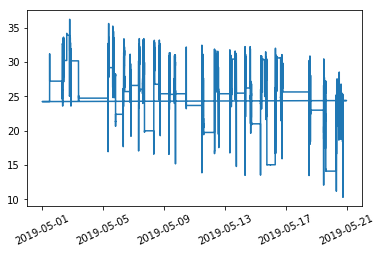

In [ ]:
plt.subplots_adjust(bottom=0.2)
plt.xticks( rotation=25 )
ax=plt.gca()
xfmt = md.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(column_timestamp["Receive Time"],column_timestamp["Fuel Information"])

In [ ]:
sns.lineplot(column_timestamp["Receive Time"],column_timestamp["Fuel Information"])

NameError: ignored

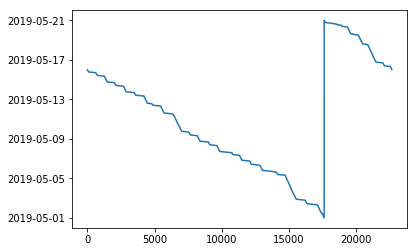

In [ ]:
plt.plot(column_timestamp["Receive Time"])

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


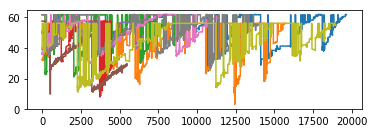

In [ ]:
df = Zero_noise(df,"Fuel Information")#320618
dt = Zero_noise(dt,"Fuel Information")#000250
dl = Zero_noise(dl,"Fuel Information")#359400
dd = Zero_noise(dd,"Fuel Information")#320501
dz = Zero_noise(dz,"Fuel Information")#267240
dn = Zero_noise(dn,"Fuel Information")#252119
do = Zero_noise(do,"fuel_litre")#252119
dq = Zero_noise(dq,"fuel_litre")#252119
dr = Zero_noise(dr,"fuel_litre")#252119



# df = Zero_noise(df,"Fuel Information")#320618
# dt = Zero_noise(dt,"Fuel Information")#000250
# dr = Zero_noise(dr,"Fuel Information")#000250
# dl = Zero_noise(dl,"Fuel Information")#000250



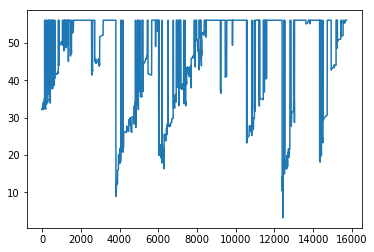

In [ ]:
plt.plot(dt)

***Fuel Data***

In [ ]:
#  dp = dt[[0]].astype(float)
# dt = dt[[0]].astype(float)
dp = pd.DataFrame()
dp = dp.append(df, ignore_index=True)
dp = dp.append(dt, ignore_index=True)
dp = dp.append(dl, ignore_index=True)
dp = dp.append(dd, ignore_index=True)
dp = dp.append(dz, ignore_index=True)
dp = dp.append(dn, ignore_index=True)
dp = dp.append(do, ignore_index=True)
dp = dp.append(dq, ignore_index=True)
dp = dp.append(dr, ignore_index=True)


#dp.reset_index(drop=True, inplace=True)
#dp = dp[dp['Fuel Information'] != 0]
# sns.distplot(dp,bins=30)
# dp.dtypes

# plt.plot(dp, label="original_Data")
# plt.legend()
# dp.shape

In [ ]:
dp["Receive Time"]

In [ ]:
dp.to_csv("/content/drive/My Drive/Machine_Learning/CSE499VTS/noisy_data.csv", encoding='utf-8', index=False)

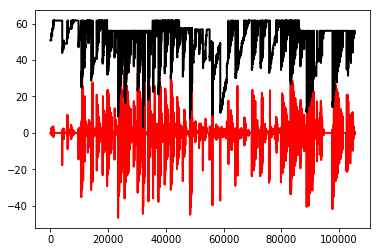

In [ ]:
ds = white_noise_filter(dp)


(105400, 1)


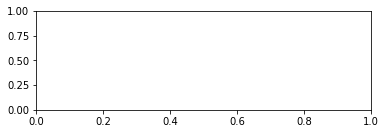

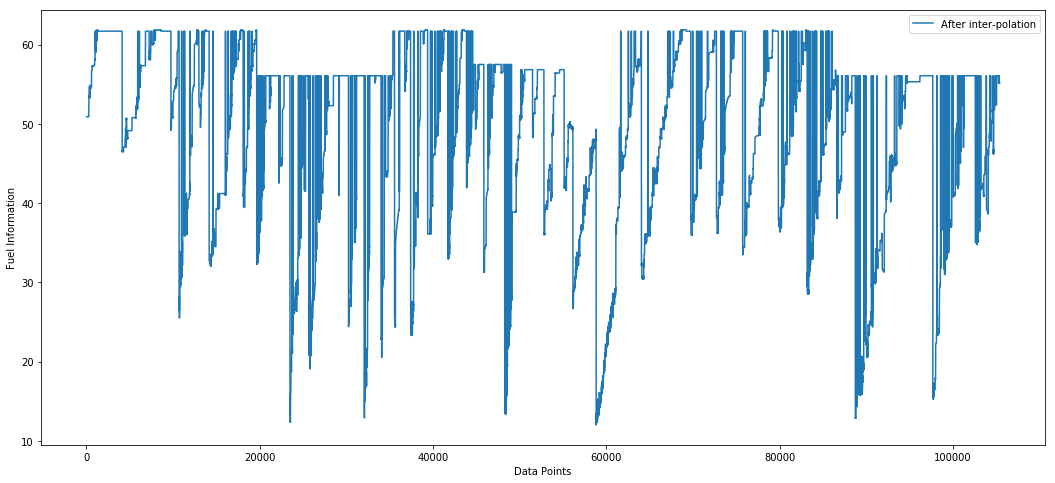

In [ ]:
dd =  filter_iqr_lower(ds,0,0.2,200)

(105400, 1)


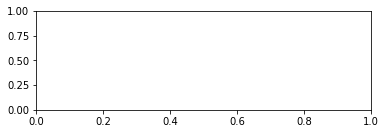

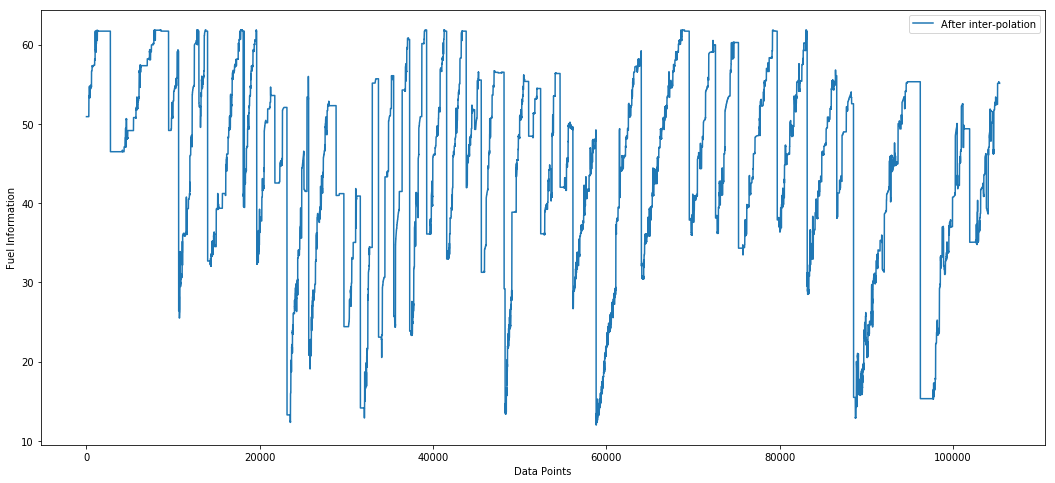

In [ ]:
dd =  filter_iqr_upper(dd,0,0.98,200)

***Cleaning First Set***

spectral 0
Agglomerative 190
spectral 380
spectral 570
spectral 760
Agglomerative 950
spectral 1140
spectral 1330
spectral 1520
spectral 1710
spectral 1900
spectral 2090
spectral 2280
spectral 2470
spectral 2660
spectral 2850
spectral 3040
spectral 3230
spectral 3420
spectral 3610
spectral 3800
Agglomerative 3990
spectral 4180
Agglomerative 4370
Agglomerative 4560
spectral 4750
spectral 4940
spectral 5130
spectral 5320
spectral 5510
spectral 5700
Agglomerative 5890
Agglomerative 6080
spectral 6270
spectral 6460
spectral 6650
spectral 6840
Agglomerative 7030
spectral 7220
spectral 7410
spectral 7600
spectral 7790
spectral 7980
spectral 8170
spectral 8360
spectral 8550
spectral 8740
spectral 8930
spectral 9120
spectral 9310
spectral 9500
Agglomerative 9690
Agglomerative 9880
spectral 10070
spectral 10260
Agglomerative 10450
Agglomerative 10640
Agglomerative 10830
Agglomerative 11020
Agglomerative 11210
Agglomerative 11400
spectral 11590
Agglomerative 11780
Agglomerative 11970
Agglomerati

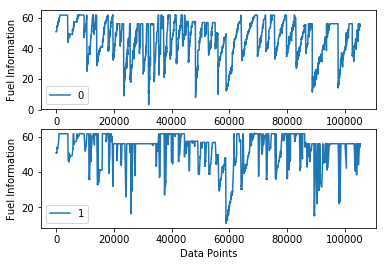

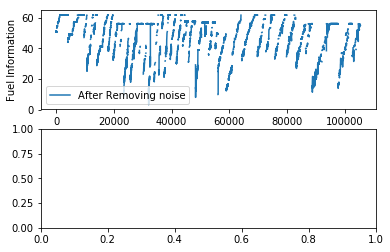

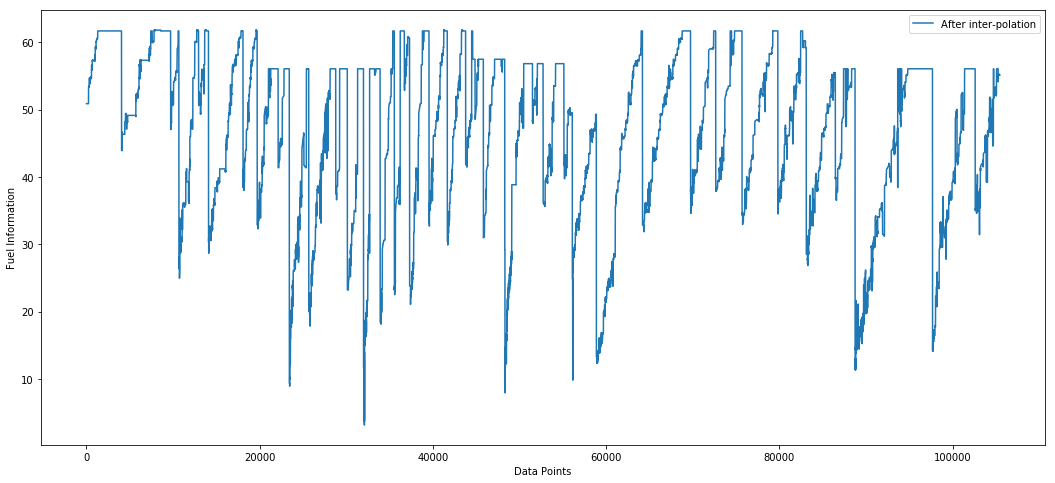

In [ ]:
S = Clustering(ds,190,1,1)

In [ ]:
# k  =  reject_outliers(dd,150,3)


In [ ]:
pywt.wavelist(kind='discrete')

/usr/local/lib/python3.6/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 12 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


(105400, 1)


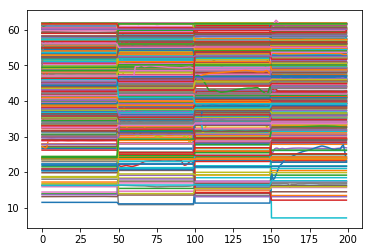

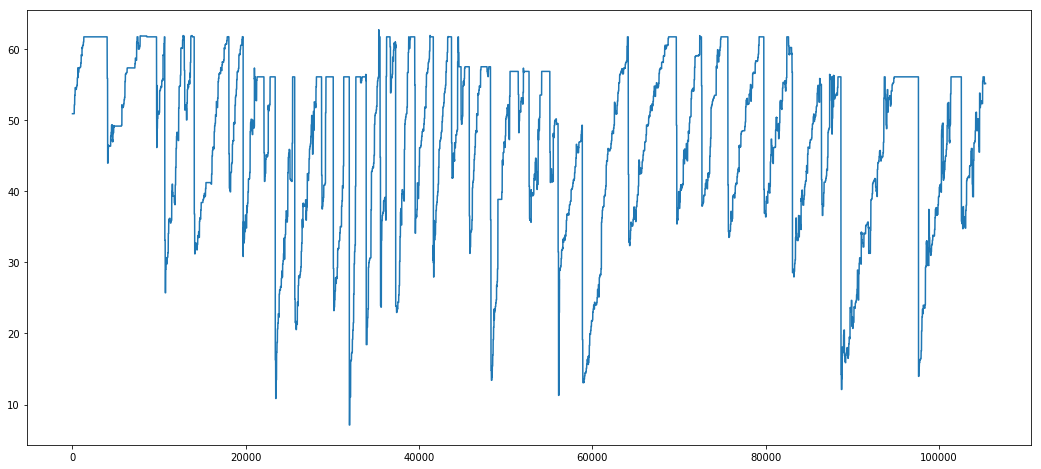

In [ ]:

T  = Mini_batch_wavelet_denoising(S,200,4,"coif2",5,12,5)

    

In [ ]:
# S.shape[0]

In [ ]:
# New_Feature =  new_feature_analysis(k)

In [ ]:
# New_Feature =  new_feature_analysis(S)

In [ ]:
# New_Feature[ 0:20].shape[0]

In [ ]:
# stolen = detecting_Stolen(New_Feature,2,4,5,2)

    index  Index_start  Index_stop     volume
0       1         4041        4042 -17.751684
1       2         9709        9710 -14.646956
2       3        10663       10664 -35.291075
3       4        10812       10813  -4.369012
4       5        12938       12939 -10.875293
5       6        14083       14084 -31.366236
6       7        18067       18162 -26.464620
7       8        19702       19773 -31.268236
8       9        19978       20070  -7.042657
9      10        21113       21196  -7.568951
10     11        22121       22122 -14.696637
11     12        23412       23413 -46.690137
12     15        24382       24450 -10.557100
13     16        25095       25096  -4.666928
14     17        25657       25658 -35.898920
15     18        26965       27035 -11.517684
16     19        27551       27552  -5.952621
17     20        27730       27731  -4.593945
18     21        27847       27848  -5.505675
19     22        28772       28773 -18.568406
20     23        30112       30113

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


    index  Index_start  Index_stop     volume
0       1         3999        4050 -17.754879
1       2         9699        9750 -12.125721
2       3        10649       10700 -35.971900
3       4        12899       12950 -10.377527
4       5        14049       14100 -30.496240
5       6        18049       18100 -21.273964
6       7        19699       19750 -35.846971
7       9        22099       22150 -14.696637
8      10        23399       23450 -45.206731
9      11        25099       25100  -4.031924
10     12        25649       25700 -34.538069
11     13        27699       27700  -4.307536
12     14        28749       28800 -18.568406
13     15        30099       30150 -32.854786
14     16        31949       31950 -48.941126
15     17        33898       33899 -37.239556
16     18        35499       35550 -37.785280
17     19        36699       36700  -6.491729
18     20        37298       37299 -36.419615
19     21        39499       39550 -27.598639
20     22        41649       41700

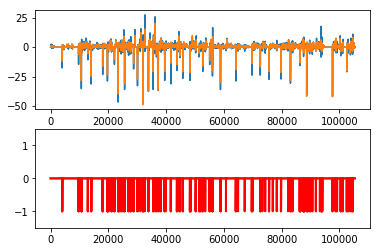

In [ ]:
refill = detecting_refill_ref(S,T,90,100,lag= 1,threshold_neuro =3,refill_th_neuro=4,threshold=3,refill_th = 4)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


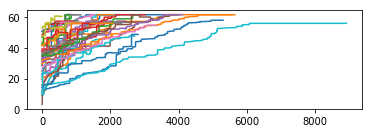

In [ ]:
S_test_final1 = filter_method(S,refill,"median",10,9)

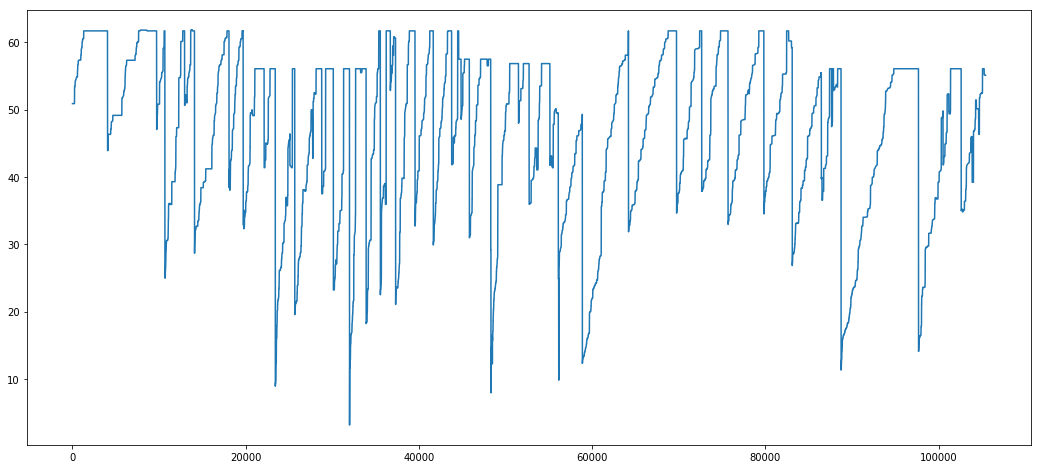

In [ ]:
plt.figure(figsize= (18,8))
plt.plot(S_test_final1)
plt.savefig('/content/drive/My Drive/Machine_Learning/filtering values.png')


/usr/local/lib/python3.6/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 12 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


(105400, 1)


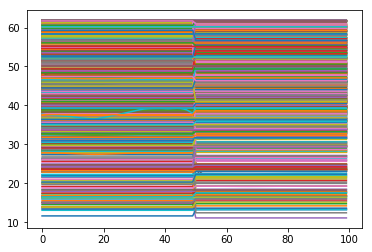

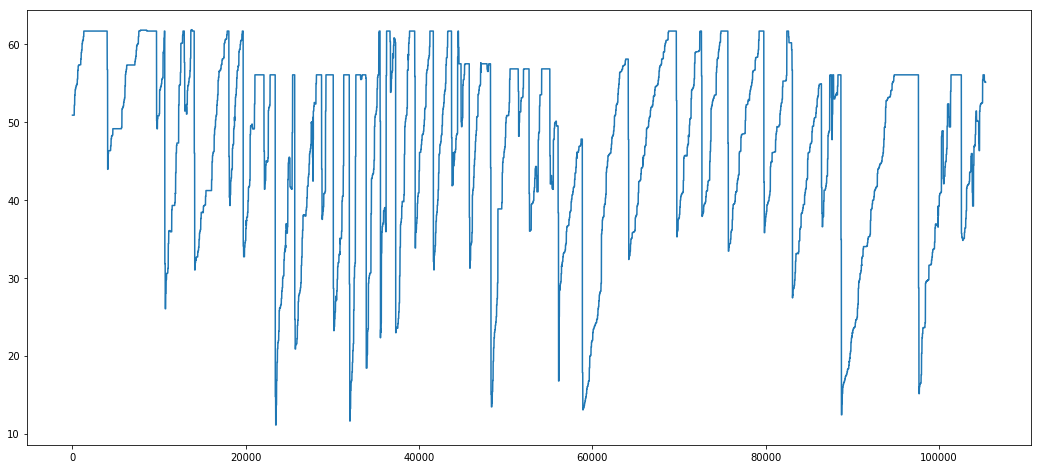

In [ ]:
L  = Mini_batch_wavelet_denoising(S_test_final1,100,2,"coif2",4,12,5)

    index  Index_start  Index_stop     volume
0       1         4041        4042 -17.751684
1       2         9709        9710 -14.646956
2       3        10663       10664 -35.291075
3       4        12938       12939 -10.875293
4       5        14083       14084 -31.366236
5       6        18067       18162 -26.464620
6       7        19702       19773 -31.268236
7       8        22121       22122 -14.696637
8       9        23412       23413 -46.690137
9      10        25095       25096  -4.666928
10     11        25657       25658 -35.898920
11     12        27730       27731  -4.593945
12     13        28772       28773 -18.568406
13     14        30112       30113 -32.854786
14     15        31979       31990 -52.913558
15     16        33898       33899 -37.635759
16     17        35540       35551 -39.186747
17     19        36694       36695  -8.342817
18     20        37298       37309 -39.573914
19     21        39543       39544 -28.369524
20     22        41653       41654

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


    index  Index_start  Index_stop     volume
0       1         3999        4050 -17.754746
1       2         9699        9700 -11.527418
2       3        10649       10700 -35.668670
3       4        12899       12950 -10.274290
4       5        14049       14100 -30.684320
5       6        18049       18100 -21.124311
6       7        19699       19700 -27.607088
7       8        22099       22150 -14.696637
8       9        23399       23450 -44.980890
9      11        25649       25700 -35.217667
10     13        28749       28800 -18.568406
11     14        30099       30150 -32.854786
12     15        31949       32000 -44.464863
13     16        33899       33900 -37.246997
14     17        35499       35551 -39.398306
15     19        36699       36700  -6.524961
16     20        37299       37300 -37.278273
17     21        39499       39550 -27.864879
18     22        41649       41650 -29.611360
19     23        43749       43800 -19.865184
20     25        44549       44600

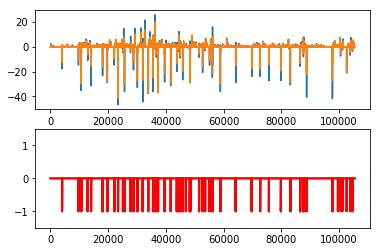

In [ ]:
refill1 = detecting_refill_ref(S_test_final1,L,90,100,lag=1,threshold_neuro =2,refill_th_neuro=4,threshold=2,refill_th = 4)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


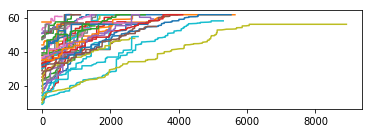

In [ ]:
S_test_final2 = filter_method(S_test_final1,refill1,"median",10,9)

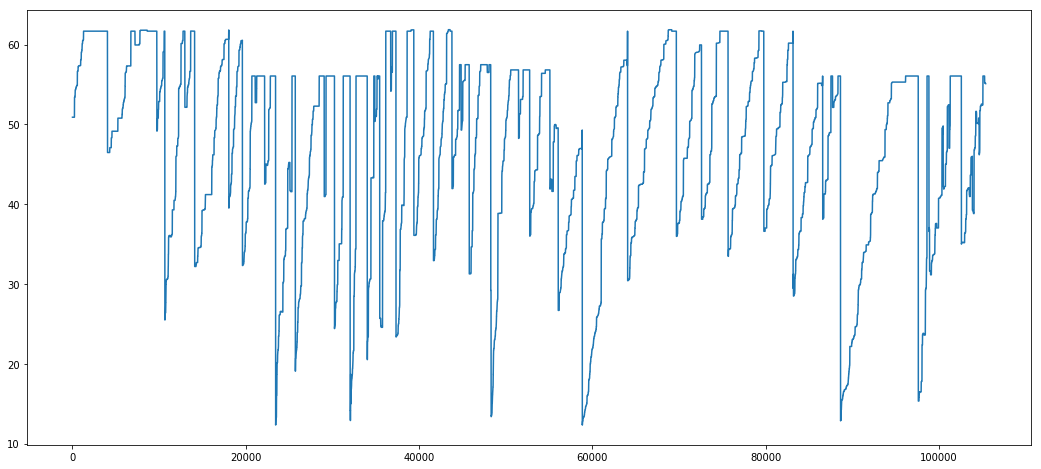

In [ ]:
plt.figure(figsize= (18,8))
plt.plot(S_test_final2)
plt.savefig('/content/drive/My Drive/Machine_Learning/filtering values.png')

    index  Index_start  Index_stop     volume
0       2        10046       10047   3.289651
1       3        10452       10453   3.248498
2       5        11459       11460   3.382112
3       6        11935       11936   3.314774
4       7        12272       12273   6.175240
5       8        12491       12492   5.093406
6      10        13640       13641   5.113322
7      16        20509       20510   4.435487
8      17        21045       21046   3.932312
9      19        22601       22602   5.867719
10     20        22797       22798   3.993139
11     23        24864       24865   5.170800
12     24        25381       25382  14.598077
13     27        29218       29219  14.878781
14     28        31109       31110   3.519377
15     29        31292       31293  15.184930
16     30        31996       31997   6.596762
17     31        32472       32473   6.032226
18     32        32679       32680  21.570772
19     34        34151       34152   4.582146
20     35        34472       34473

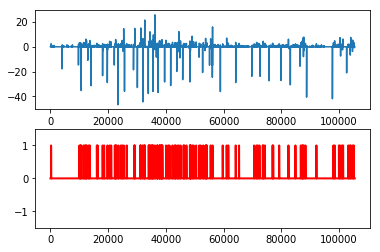

In [ ]:
refill_after_false = remove_false_peaks(refill1,S_test_final2,diff = 2 ,lag = 1,threshold_stole = 2,refill_th = 3 ,ranges_ref = 10 ,ranges = 250 )

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


    Index_start  Index_stop     volume
0          4041        4042 -17.751684
1          9709        9710 -14.646956
2         10663       10664 -35.291075
3         12938       12939 -10.875293
4         14083       14084 -31.366236
5         18052       18163 -23.664488
6         19687       19783 -29.391112
7         22121       22122 -14.696637
8         23412       23413 -46.690137
9         25657       25658 -35.898920
10        28772       28773 -18.568406
11        30112       30113 -32.854786
12        31964       31990 -52.913558
13        33898       33899 -37.635759
14        35525       35551 -39.186747
15        36694       36695  -8.342817
16        37283       37309 -39.573914
17        39543       39544 -28.369524
18        41653       41654 -31.276375
19        43770       43771 -19.869946
20        44859       44860  -8.934368
21        45817       45818 -26.518035
22        48269       48337 -46.492465
23        51489       51490  -8.395033
24        52715       527

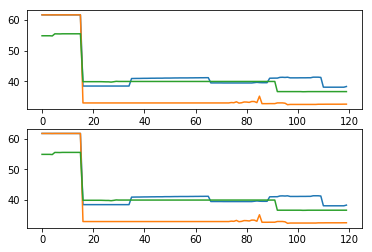

In [ ]:
refill2 =  Peak_analysis_IQR(S_test_final2,dr,refill_after_false,0,1,0,1,"interp","both",1,0.100)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


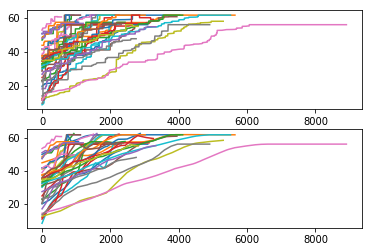

In [ ]:
S_test_final3 = filter_method(S_test_final2,refill2 ,"both",10,9)

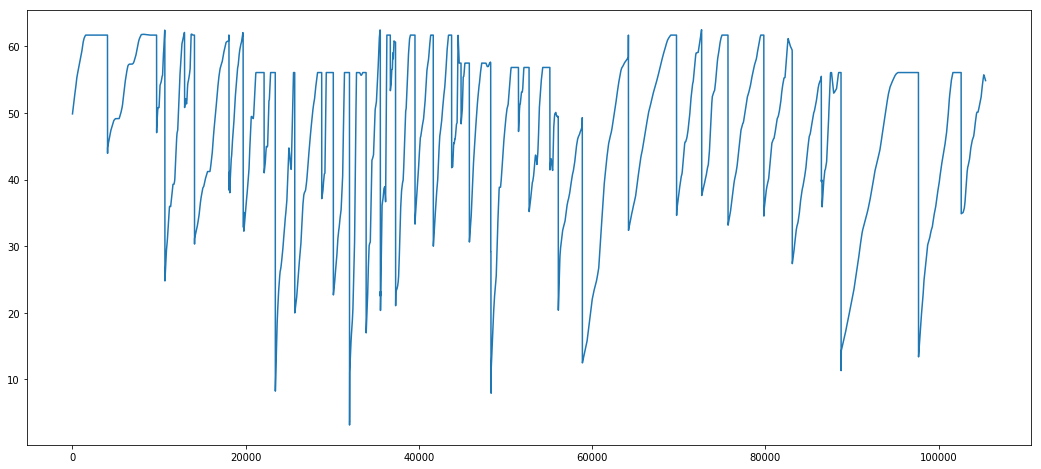

In [ ]:
plt.figure(figsize= (18,8))
plt.plot(S_test_final3)
plt.savefig('/content/drive/My Drive/Machine_Learning/filtering values.png')

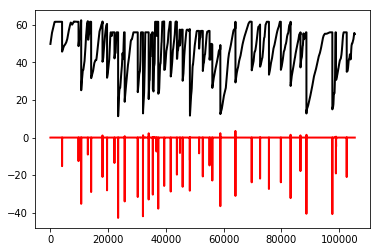

In [ ]:
usage_data =  new_feature_analysis(S_test_final3)

In [ ]:
data =  Usage_data(usage_data,refill2)

In [ ]:
real = [17.77,14.65,36.89,9.8,33.25,23.54,29.202177,14.66,47.14,36.8,0,32.79,45.71,37.915,38.46,8.342817,40.62,28.98,31.79,19.8,8.65,26.31,46.35,8.84,20.86,14.94,24.56,37.47,28,28,27.27,28.79,27,34.85,15.045849,44.7,41.97,24.07,0]

In [ ]:
data.shape

(39, 5)

In [ ]:
len(real)

39

In [ ]:
data["real_value"] = real

In [ ]:
data["error"] = abs(data["Refill_value"]+data["real_value"])

In [ ]:
data["error_percentage"] = abs((data['Refill_value']+data["real_value"])/data['real_value'])*100

In [ ]:
data.style.format({
    'error_percentage': '{:,.3f}%'.format,
    'error': '{:,.3f}'.format
      
  })

,Start_index_refill,Stop_index_refill,Refill_value,After_refill_usage,total_fuel_usage,real_value,error,error_percentage
0,4041,4042,-17.7517,-3.41846,-3.41846,17.77,0.018,0.103%
1,9709,9710,-14.647,15.2128,11.7943,14.65,0.003,0.021%
2,10663,10664,-35.2911,-35.2911,-23.4967,36.89,1.599,4.334%
3,12938,12939,-10.8753,36.7375,13.2407,9.8,1.075,10.972%
4,14083,14084,-31.3662,-0.269664,12.9711,33.25,1.884,5.665%
5,18052,18163,-23.6645,-21.262,-8.29091,23.54,0.124,0.529%
6,19687,19783,-29.3911,-8.66437,-16.9553,29.2022,0.189,0.647%
7,22121,22122,-14.6966,22.9141,5.95883,14.66,0.037,0.250%
8,23412,23413,-46.6901,-1.42109e-14,5.95883,47.14,0.450,0.954%
9,25657,25658,-35.8989,1.42109e-14,5.95883,36.8,0.901,2.449%


In [ ]:
data.to_excel('/content/drive/My Drive/Machine_Learning/data_with_time series/results.xlsx',sheet_name = "Device Log Data",index = False)

In [ ]:
 plt.figure(figsize=(20,10))
 plt.scatter(abs(data['Refill_value']),data['real_value'],marker='o', linestyle='-', color='r',) 
 label='Square'
 plt.xlabel("Detected Value")
 plt.ylabel("Actual Value")
 plt.savefig('/content/drive/My Drive/Machine_Learning/Detected vs Actual.png')
  


KeyError: ignored

<Figure size 1440x720 with 0 Axes>

In [ ]:
data.to_csv("/content/drive/My Drive/Machine_Learning/CSE499VTS/result.csv", encoding='utf-8', index=False)

NameError: ignored

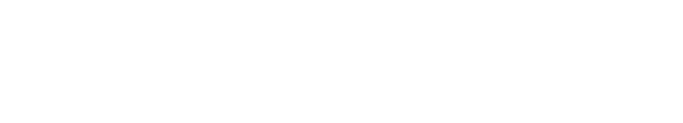

In [ ]:

fig, ax = plt.subplots(figsize=(12, 2)) # set size frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
tabla = table(ax, data, loc='upper right', colWidths=[0.3]*len(data.columns))  # where df is your data frame
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
tabla.scale(1.2, 1.2) # change size table
plt.savefig('/content/drive/My Drive/Machine_Learning/Data/Result.png', transparent=True)

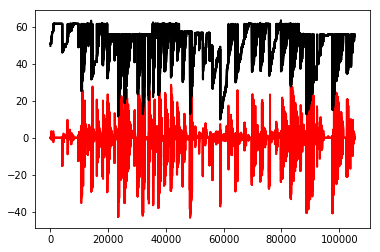

In [ ]:
New_initial_step = new_feature_analysis(dd) 

#clustering and wavlet
New_First_step = new_feature_analysis(S)  #after clustering
New_Second_step = new_feature_analysis(T) #after wavelet

#median and Wavelet
New_Third_step = new_feature_analysis(S_test_final1) #after median
New_Fourth_step = new_feature_analysis(L) # after wavelet

# median and peak valda
New_Fifth_step = new_feature_analysis(S_test_final2) #median filter
New_Sixth_step = new_feature_analysis(S_test_final3) # median filter

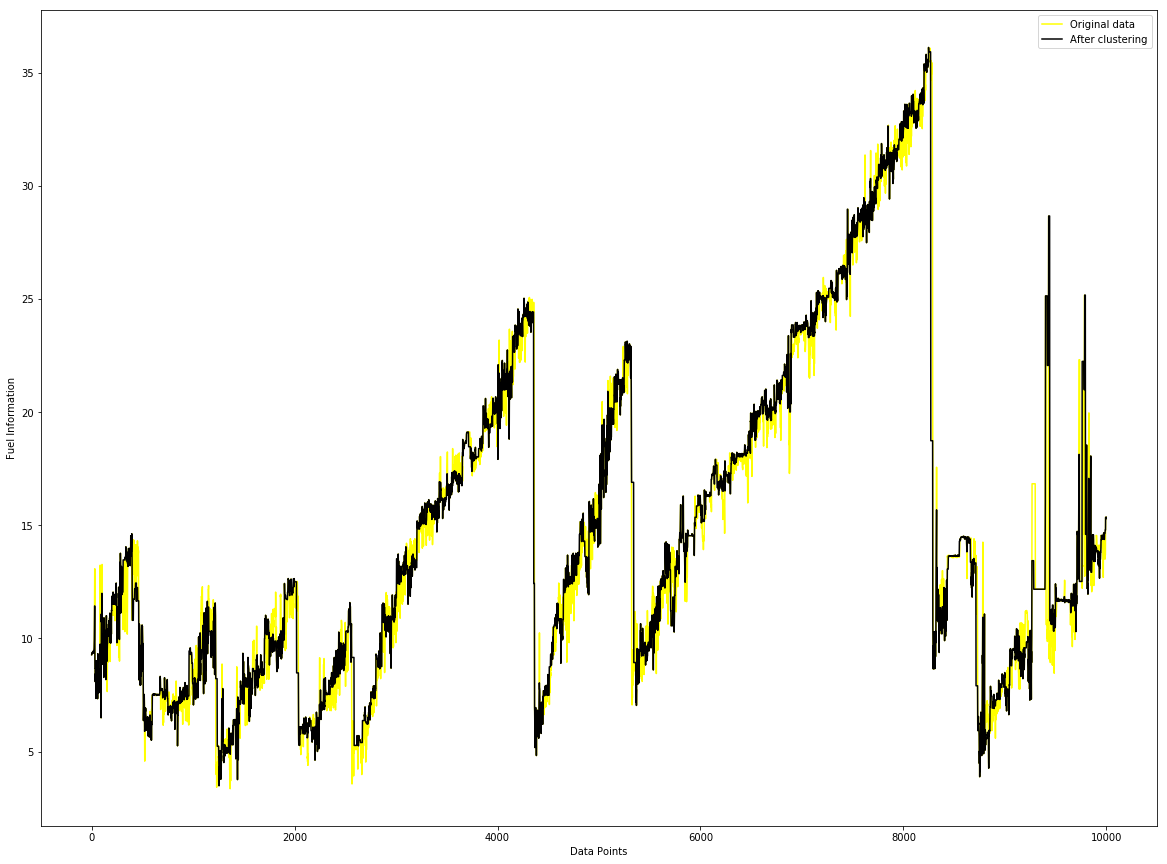

In [ ]:
 plt.figure(figsize=(20,15))
 plt.plot(New_initial_step.index.values,New_initial_step[0],color='yellow',label = "Original data")
 plt.plot(New_First_step.index.values,New_First_step[0],color='k',label = "After clustering")
 plt.xlabel("Data Points")
 plt.ylabel("Fuel Information")
 plt.legend()


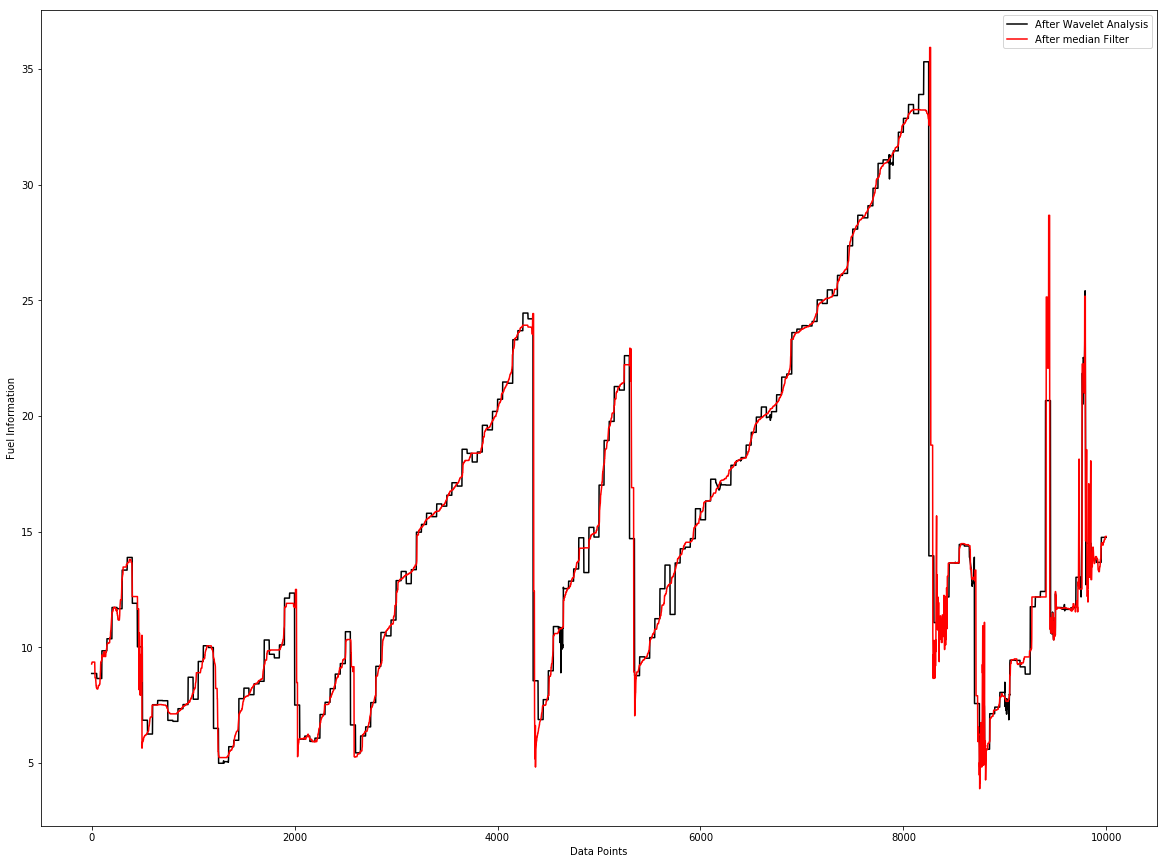

In [ ]:
plt.figure(figsize=(20,15))

plt.plot(New_Second_step.index.values,New_Second_step[0],color='black',label = 'After Wavelet Analysis')
plt.plot(New_Third_step.index.values,New_Third_step[0],color='red', label = 'After median Filter')


plt.xlabel("Data Points")
plt.ylabel("Fuel Information")
plt.legend()

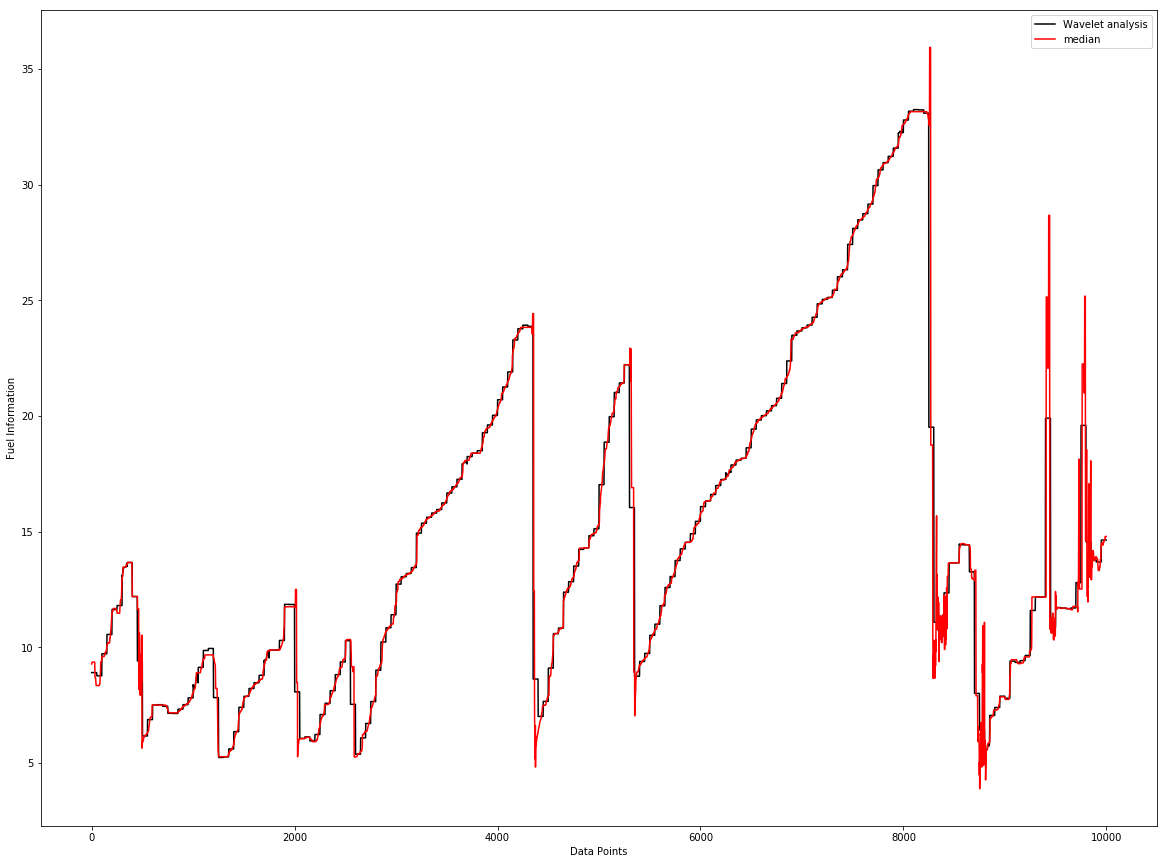

In [ ]:
plt.figure(figsize=(20,15))
plt.plot(New_Fourth_step.index.values,New_Fourth_step[0],color='black',label = 'Wavelet analysis')
plt.plot(New_Fifth_step.index.values,New_Fifth_step[0],color='red',label = 'median')
plt.xlabel("Data Points")
plt.ylabel("Fuel Information")
plt.legend()

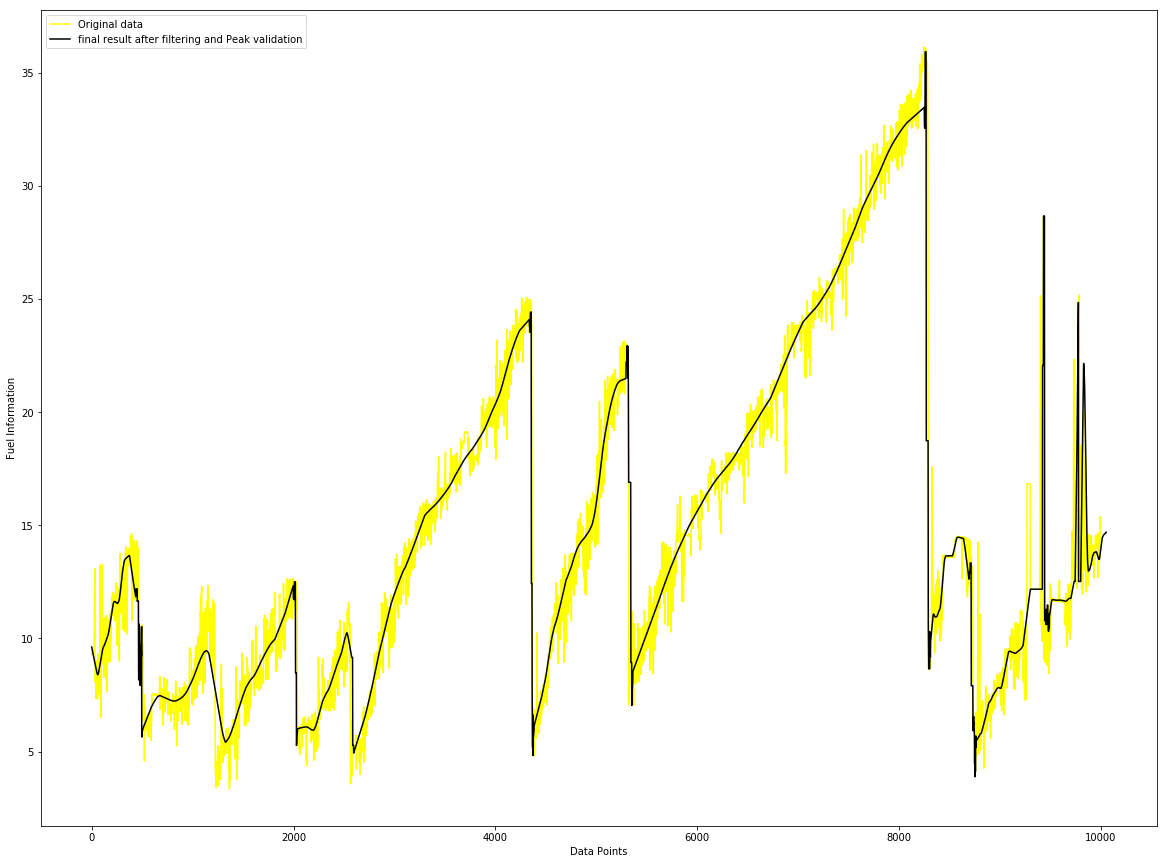

In [ ]:
plt.figure(figsize=(20,15))
plt.plot(New_initial_step.index.values,New_initial_step[0],color='yellow',label = "Original data")
plt.plot(New_Sixth_step.index.values,New_Sixth_step[0],color='black',label = 'final result after filtering and Peak validation')
plt.xlabel("Data Points")
plt.ylabel("Fuel Information")
plt.legend()

In [ ]:
data2 = pd.DataFrame({'Time Receieved': dp["Receive Time"], 'Initial_fuel': New_initial_step[0], 'First_fuel':New_First_step[0], 'Second_fuel': New_Second_step[0], 'Third_fuel': New_Third_step[0],'Fourth_fuel': New_Third_step[0],'Fifth_fuel': New_Fifth_step[0],'Sixth_fuel': New_Sixth_step[0]})

In [ ]:
data2.to_excel('/content/drive/My Drive/Machine_Learning/data_with_time series/old_data.xlsx',sheet_name = "Device Log Data",index = False)